# $t\bar{t}$ fits

**Motivation** I think in the `ttbar-proposal` nb I was gaining a good understanding of the problem, but since (I think) I even need fewer columns loaded in for the limits, I'll try a slimmed down version of the setup here to avoid the memory issues I was seeing when running on the centos machines before.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.optimize import curve_fit

import os
              
os.sys.path+= ['../stats-results/','../non-resonant-studies/','../code/','../pyhf-4b-timing/']

from lim_utils import lumi as L 
from utils import systs, calc_bstrap, get_wlab, cat_sel
from utils import enrichedRegions, f, getFit
import pyhf

from quad45_2x2 import res_bin_edges

from eventDisplays import rainbow_text

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

Using uproot4


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
yr = 16
mc = 'mc16a'
#bcat='3b1f'
bcat='4b'

In [41]:
fDir = '../data/RR/cryptotuples/ggF_rw_pre_Xwt/'

dat_name = f'{fDir}/data{yr}_NN_100_bootstraps.root'
ah_name  = f'{fDir}/NanoNTuple_allhad_{mc}_NN_100_bootstraps.root'
sl_name  = f'{fDir}/NanoNTuple_semilep_{mc}_NN_100_bootstraps.root'

sm_name  = f'../../hh4b/hh4b-resolved-reconstruction/SMNR_pythia_{mc}.root'

In [4]:
wl = get_wlab(bcat)

In [5]:
with uproot.open(f'{dat_name}') as fd:
    bl = '' if bcat=='4b' else f'_{bcat}'
    
    norm = fd[f'NN_norm{bl}_bstrap_med_{yr}'].all_members['fVal']
    norm_VR = fd[f'NN_norm{bl}_bstrap_med_{yr}'].all_members['fVal']
    norm_IQR = fd[f'NN_norm{bl}_bstrap_IQR_{yr}'].all_members['fVal']
    print(fd.keys())

['sig;1', 'validation;1', 'control;1', 'NN_norm_3b1l_bstrap_med_16;1', 'NN_norm_3b1l_bstrap_IQR_16;1', 'NN_norm_VRderiv_3b1l_bstrap_med_16;1', 'NN_norm_VRderiv_3b1l_bstrap_IQR_16;1', 'X_wt_cut_for_rw_3b1l;1', 'NN_norm_3b1f_bstrap_med_16;1', 'NN_norm_3b1f_bstrap_IQR_16;1', 'NN_norm_VRderiv_3b1f_bstrap_med_16;1', 'NN_norm_VRderiv_3b1f_bstrap_IQR_16;1', 'X_wt_cut_for_rw_3b1f;1', 'NN_norm_bstrap_med_16;1', 'NN_norm_bstrap_IQR_16;1', 'NN_norm_VRderiv_bstrap_med_16;1', 'NN_norm_VRderiv_bstrap_IQR_16;1', 'X_wt_cut_for_rw;1']


In [6]:
norm

1.0509904821094411

In [7]:
figDir = 'figures/ttbar/rings/'

In [8]:
hist_dict = {}

for fname,physSample,w,s,pre in zip([dat_name,ah_name,sl_name],['dat','ah','sl'],
                                    [None,'mc_sf','mc_sf'],[1,L[yr],L[yr]],['','mc_','mc_']):
        
    for tname, region in zip(['control','validation','sig'],['cr','vr','sr']):
        
        k = f'{physSample}_{region}'

        hist_dict[f'{k}_2b']   = enrichedRegions(fname, tname, bcat=f'rw_to_{bcat}', w_col=w,scale=s)
        hist_dict[f'{k}_{bcat}'] = enrichedRegions(fname, tname, bcat=bcat, w_col=w,scale=s)
        hist_dict[f'{k}_rw_to_{bcat}'] = enrichedRegions(fname, tname, bcat=f'rw_to_{bcat}', 
                                                         w_col=f'{pre}NN_{wl}_weight_bstrap_med_{yr}',
                                                         scale=s)
        
        hist_dict[f'{k}_rw_to_{bcat}_vr'] = enrichedRegions(fname, tname, bcat=f'rw_to_{bcat}', 
                                                            w_col=f'{pre}NN_{wl}_weight_VRderiv_bstrap_med_{yr}',
                                                            scale=s)
        

In [9]:
list(hist_dict[f'ah_cr_rw_to_{bcat}'].astype(float))[0].dtype

dtype('float64')

In [10]:
hist_dict['dat_cr_2b']

array([  3702,  28059, 560854])

In [11]:
with uproot.open(ah_name) as ahf:
    print( ahf['sig'].keys())

['run_number', 'event_number', 'pass_vbf_sel', 'mc_sf', 'trig_sf', 'jet_trig_sfs', 'truth_mhh', 'ntag', 'njets', 'X_hh', 'kinematic_region', 'm_min_dj', 'm_max_dj', 'pairing_score_1', 'pairing_score_2', 'bkt_lead_jet_pt', 'bkt_third_lead_jet_pt', 'bkt_HT', 'bucket_passed', 'cos_theta_star', 'm_hh_cor', 'm_hh', 'pt_hh', 'dEta_hh', 'X_wt_tag', 'X_wt_notag', 'X_wt_nonHCWjets', 'passMuonIso', 'trig_bucket', 'm_h1', 'E_h1', 'pT_h1', 'eta_h1', 'phi_h1', 'm_h2', 'E_h2', 'pT_h2', 'eta_h2', 'phi_h2', 'm_h1_j1', 'E_h1_j1', 'pT_h1_j1', 'eta_h1_j1', 'phi_h1_j1', 'tag_h1_j1', 'quantile_h1_j1', 'angle_h1_j1', 'm_h1_j2', 'E_h1_j2', 'pT_h1_j2', 'eta_h1_j2', 'phi_h1_j2', 'tag_h1_j2', 'quantile_h1_j2', 'angle_h1_j2', 'm_h2_j1', 'E_h2_j1', 'pT_h2_j1', 'eta_h2_j1', 'phi_h2_j1', 'tag_h2_j1', 'quantile_h2_j1', 'angle_h2_j1', 'm_h2_j2', 'E_h2_j2', 'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2', 'quantile_h2_j2', 'angle_h2_j2', 'minQ', 'pT_4', 'pT_2', 'eta_i', 'dRjj_1', 'dRjj_2', 'm_vbf_j1', 'E_vbf_j1', 'p

In [12]:
cols = ['pass_vbf_sel','X_wt_tag',f'rw_to_{bcat}',
        'ntag','minQ','m_hh','X_hh','dEta_hh',
        f'NN_{wl}_weight_bstrap_med_{yr}', 
        f'NN_{wl}_weight_bstrap_IQR_{yr}', 
        f'NN_{wl}_weight_VRderiv_bstrap_med_{yr}']

**Note:** If I'm jsonifying - it *might* be more useful to return a list???

But can iterate on this point _later_ haha :)

**Step 1:** scaling 2b

$$SF = \frac{data}{mc}$$

In [13]:
alpha_2b = hist_dict['dat_cr_2b'][0] / hist_dict['sl_cr_2b'][0]

alpha_2b

0.8512064356009034

In [14]:
hist_dict[f'qcd_cr_rw_to_{bcat}'] = hist_dict[f'dat_cr_rw_to_{bcat}'] \
                                 - hist_dict[f'ah_cr_rw_to_{bcat}'] \
                                 - alpha_2b * hist_dict[f'sl_cr_rw_to_{bcat}']

In [15]:
hist_dict[f'dat_cr_rw_to_{bcat}']

array([  142.81383125,  1165.71617724, 10812.50837788])

In [16]:
hist_dict[f'qcd_cr_rw_to_{bcat}'] / hist_dict[f'dat_cr_rw_to_{bcat}']

array([0.03055344, 0.52582506, 0.80659072])

In [17]:
labels = [r'semi-lep $t\bar{t}$',r'all-had $t\bar{t}$','qcd est']
colors = ['dodgerblue','limegreen','gold']

**Step 2:** Prefit plot for 4b

(I ended up functionifying and putting it after the combined 4b fits.)


In [19]:
p, cov,alpha_2b_i = getFit(hist_dict,target=bcat)

In [21]:
alpha_2b_i

0.8512064356009034

In [22]:
def showCorr(cov,title='',cmap='PiYG',figDir='',tag='',l=labels):
    '''
    Given a .csv file returned from Sean's plot_pulls.py file (run w/ the 
    --correlations flag), visualize the correlation matrix!
    '''
    
    # Step 2: Draw the plot
    plt.figure(figsize=(5,5))
    ax = plt.gca()

    v_abs = np.max(np.abs(cov))
    im = ax.imshow(cov,cmap=cmap,vmin=-v_abs,vmax=v_abs)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax.set_xticks(range(len(l)))
    ax.set_yticks(range(len(l)))
    ax.set_xticklabels(l,rotation=90*(1-1.2/len(l)))
    ax.set_yticklabels(l)

    
    # Step 3: Overlay the #s
    for i in range(len(l)):
        for j in range(len(l)):
            cij = cov[i,j]

            ax.text(i,j,f'{cij:.0g}',ha='center',va='center')

    ax.set_title(title,loc='left')
    ax.tick_params(which='minor', length=0)
    
    # Step 4: Save
    if figDir and tag:
        plt.savefig(f'{figDir}/fitCorr_{tag}.pdf', bbox_inches='tight')


In [23]:
bcat_to_label = {
    '4b': '4b',
    '3b1l': '3b + 1 loose',
    '3b1f': '3b + 1 fail'
}

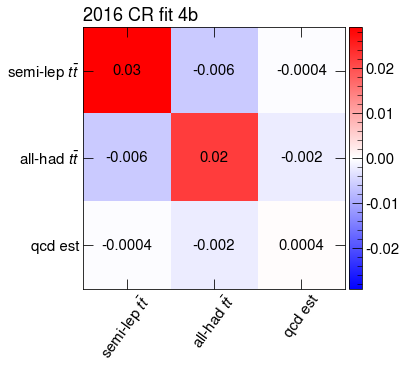

In [24]:
showCorr(cov,f'20{yr} CR fit {bcat_to_label[bcat]}',cmap='bwr',figDir=figDir,tag=f'{region}{yr}_{bcat}')

In [25]:
err = np.sqrt(np.diag(cov))
err

array([0.17095959, 0.14887025, 0.01950485])

In [26]:
np.append(0,err)

array([0.        , 0.17095959, 0.14887025, 0.01950485])

In [38]:
def fitYields(hist_dict,p=np.ones(3),err=None,region='cr',target='3b1f',train='',
              show_rw=False,figDir=''):
    '''
    Compare the pre and post-fit plots
    '''
    lw=2.5
    e = np.arange(-.5,3,1)

    fig, ax = plt.subplots(2,1,figsize=(6, 6), sharex=True,
                           gridspec_kw={"height_ratios": [.66,.34],
                                        "hspace":0.1, "left":0.1, "bottom":.25})

    keys = [f'sl_{region}_{target}',f'ah_{region}_{target}',f'qcd_{region}_rw_to_{target}{train}']
    hists = [hist_dict[k] for k in keys]

    prev = 0
    for h,pi,c,l in zip(hists,p,colors,labels):

        ax[0].hist(range(3),e, weights=pi*h,bottom=prev,color=c,label=l)
        prev+=pi*h

    y = hist_dict[f'dat_{region}_{target}']
    ax[0].errorbar(range(3),y,np.sqrt(y),.5,lw=0,elinewidth=lw,
                   color='k',marker='o',label=bcat_to_label[target])

    # And the ratio panel
    pred = np.vstack(p.reshape(-1,1)*hists).sum(axis=0)
    
    print('4b / pred',y/pred)
    #print(bcat,y)
    
    
    ax[1].errorbar(range(3),y/pred, np.sqrt(y)/pred,.5,
                   lw=0,elinewidth=lw,color='k',marker='o')

    
    if show_rw:
        rw = hist_dict[f'dat_{region}_rw_to_{target}']
        ax[0].plot(range(3),rw,color='deeppink',lw=0,marker='s')
        ax[1].plot(range(3),rw/pred,color='deeppink',lw=0,marker='s')
    
    if err is not None:
        # Hatched line for the error on the prediction
        ax[1].fill_between(e,np.append(0,1-err), np.append(0,1+err),step="pre", 
                           facecolor='None',edgecolor='dimgrey', hatch='\\\\\\\\',lw=0)            
        ti='post'
    else:
        ti='pre'
        
    ax[0].text(.41,.9,f'{ti}-fit',transform=ax[0].transAxes,
               ha='left',va='top',fontsize=20)
        
    ax[0].set_ylabel('Entries',ha='right',y=1)
    ax[1].set_ylabel(f'{target} / pred')

    ax[0].set_title(f'2016 {region} (rings), no trig bucket input',loc='left')
    ax[0].legend()
    plt.xticks(range(3),['iso $\mu$','$X_{wt}$ < 0.75','$X_{wt}$ > 0.75'])

    ax[0].tick_params('x',which='minor',length=0)
    ax[1].tick_params('x',which='minor',length=0)
    ax[0].set_xlim(e[0],e[-1])
    ax[1].plot([e[0],e[-1]],[1]*2,'k',ls='dotted',lw=lw)
    ax[1].set_ylim(0.9,1.1)

    if figDir:
        plt.savefig(f'{figDir}/{ti}Fit-{region}{yr}_{bcat}.pdf', bbox_inches='tight')



In [37]:
96/62.49298375

1.5361724507193177

4b / pred [1.53617245 1.31948482 1.15307338]
4b / pred [1. 1. 1.]


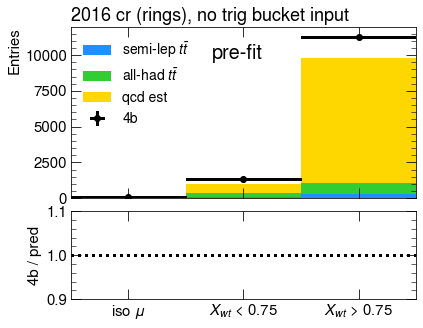

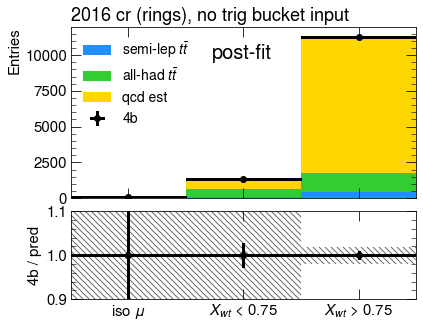

In [39]:
fitYields(hist_dict,target=bcat,figDir=figDir)
fitYields(hist_dict,p,err,target=bcat,figDir=figDir)

**Request from Sean:** Compare to what I have rn.

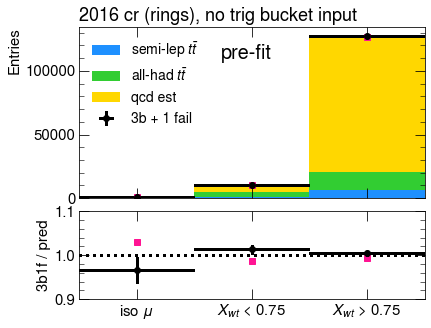

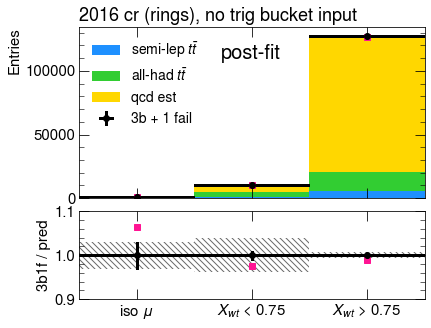

In [47]:
fitYields(hist_dict,target=bcat,show_rw=True)
fitYields(hist_dict,p,err,target=bcat,show_rw=True)

**Rinse and repeat for the VR**

In [10]:
with open(f'../stats-results/ggF_PUSH/ws-{bcat}-systs-HTcut-300.0-16-SM-HH-ttbar_test.json') as fi:
    ws_in = json.load(fi)

In [11]:
ws_in

{'channels': [{'name': 'channel164b',
   'samples': [{'name': 'signal164b',
     'data': [0.0013734735495745556,
      0.0065071728979091865,
      0.020007264753985513,
      0.06866399719583574,
      0.1214882761165428,
      0.23039867204316664,
      0.3227717383061198,
      0.4027061547535855,
      0.5080130292934519,
      0.5057391179975204,
      0.5261550712484522,
      0.5063046390781651,
      0.5149528761466602,
      0.4207967134603847,
      0.43466453586479936,
      0.34568251141117745,
      0.30542800772699064,
      0.2871071492552213,
      0.21043869105906854,
      0.18708505927484076,
      0.1493177736276472,
      0.13820200207246192,
      0.1098712004325586,
      0.0843800834489512,
      0.06457746185533342,
      0.047082626703011776,
      0.03371235591876065,
      0.06159477309443062],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None}]},
    {'name': 'background164b',
     'data': [22.401401352873485,
      58.01414425170039,
   

In [50]:
?getFit

In [29]:
p_vr, cov_vr, alpha_2b_VR = getFit(hist_dict,'vr',bcat,'_vr')
err_vr = np.sqrt(np.diag(cov_vr))

In [30]:
cov_vr

array([[ 0.04477883, -0.00818011, -0.00064926],
       [-0.00818011,  0.02322522, -0.00289552],
       [-0.00064926, -0.00289552,  0.00075802]])

In [31]:
p

array([1.56810032, 1.71516076, 1.08978777])

In [32]:
p_vr

array([1.65327689, 1.31118162, 1.12851035])

In [33]:
err_vr

array([0.2116101 , 0.15239824, 0.02753207])

In [128]:
dfi = dat.query('(X_wt_tag > 1.5) & rw_to_3b1f')

In [129]:
dfi.head()

pass_vbf_sel  X_wt_tag  rw_to_3b1f  ntag  minQ        m_hh      X_hh  \
0         False  5.017101        True     2     1  400.801331  1.036359   
1         False  5.697348        True     2     1  490.984985  1.108583   
2         False  4.782486        True     2     1  374.754547  1.597552   
3         False  3.134141        True     2     1  320.685883  0.627865   
4         False  6.405104        True     2     1  619.658691  1.415064   

    dEta_hh  NN_d231f_weight_bstrap_med_16  NN_d231f_weight_bstrap_IQR_16  \
0  0.201769                       0.031452                       0.011256   
1  1.349937                       0.072791                       0.014920   
2  0.843274                       0.049580                       0.012980   
3  0.329589                       0.049655                       0.025373   
4  0.301860                       0.142345                       0.031966   

   NN_d231f_weight_VRderiv_bstrap_med_16    pT_h1_j1    pT_h1_j2    pT_h2_j1  \
0                               0.067433  121.687027   83.354614   82.285614   
1                               0.069555  122.359413   83.152969  102.272507   
2                               0.051260   93.895462   61.416775  124.657036   
3                               0.065423   58.136486   51.122887   76.336441   
4                               0.129833  272.728210  145.985413  108.233940   

    pT_h2_j2  
0  71.984291  
1  63.341671  
2  51.159668  
3  41.160923  
4  98.521896

In [126]:
dfi.X_wt_tag.min()

1.5000014

4b / pred [1.73108408 1.24731165 1.1639492 ]
4b / pred [1. 1. 1.]


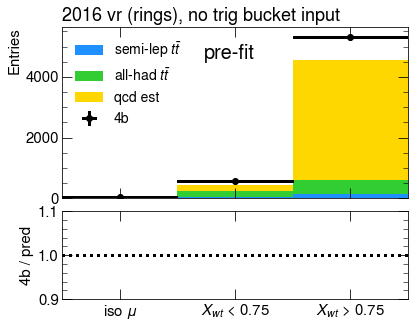

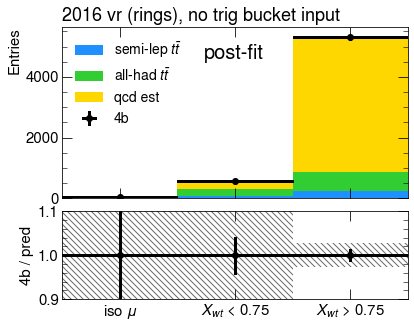

In [40]:
fitYields(hist_dict,region='vr',target=bcat,train='_vr',figDir=figDir)
fitYields(hist_dict,p_vr,err_vr,'vr',target=bcat,train='_vr',figDir=figDir)

**Thoughts:** Ok, so the discrepancy is *quite* a bit bigger - but I guess the good news here is, it's fandamnfuckingtastic that I am seeing this deiscrepancy in the VR and now I *know* how to account for it. :) 

**Follow-up:** Am I using the VR derived networks for the VR estimate?

In [58]:
p

array([0.9664195 , 1.04801856, 1.0011778 ])

In [59]:
p_vr

array([0.95858799, 0.97783255, 1.00583978])

**Compare the nominal estimates in the SR**

In [60]:
pt_cols = ['pT_h1_j1','pT_h1_j2','pT_h2_j1','pT_h2_j2']

In [61]:
sig_cols = [c for c in cols if 'NN' not in c and 'rw_to_' not in c]

sig_cols

['pass_vbf_sel', 'X_wt_tag', 'ntag', 'minQ', 'm_hh', 'X_hh', 'dEta_hh']

In [62]:
tname = 'sig'

dat = uproot.open(f'{dat_name}:{tname}').arrays(cols + pt_cols, library='pd')
ah  = uproot.open(f'{ ah_name}:{tname}').arrays(cols+['mc_sf'], library='pd')
sl  = uproot.open(f'{ sl_name}:{tname}').arrays(cols+['mc_sf'], library='pd')

sig_cols = [c for c in cols if 'NN' not in c and 'rw_to_' not in c]
sm  = uproot.open(f'{ sm_name}:{tname}').arrays(sig_cols+['mc_sf'], library='pd')

ah['mc_sf'] *= L[yr]
sl['mc_sf'] *= L[yr]
sm['mc_sf'] *= L[yr]

In [86]:
fi = uproot.open(sm_name)

h = fi['ggF_FourTagCutflow'] 
cutflow = pd.DataFrame(h.to_numpy()[0],
                       index=h.all_members['fXaxis'].all_members['fLabels'],
                       columns=['ggF_FourTagCutflow'])
cutflow

ggF_FourTagCutflow
Initial                         25860.987726
Selected                        25860.987726
NTuple                              7.603843
Trigger                             4.241000
ggF channel                         4.191194
4 good jets, >= 2 tagged            3.337993
Multi Tagged                        0.841467
Valid                               0.841467
Trigger Buckets                     0.803343
dEta_hh                             0.670679
Main Xwt                            0.670679
Signal                              0.295702
Validation                          0.116335
Control                             0.088575

In [79]:
xaxis = h.all_members['fXaxis']

In [85]:
for l in xaxis.all_members['fLabels']:
    print(l)

Initial
Selected
NTuple
Trigger
ggF channel
4 good jets, >= 2 tagged
Multi Tagged
Valid
Trigger Buckets
dEta_hh
Main Xwt
Signal
Validation
Control


In [75]:
uproot.__version__

'4.0.4'

array([2.58609877e+04, 2.58609877e+04, 7.60384334e+00, 4.24100015e+00,
       4.19119429e+00, 3.33799349e+00, 8.41466512e-01, 8.41466512e-01,
       8.03343159e-01, 6.70678576e-01, 6.70678576e-01, 2.95701808e-01,
       1.16334602e-01, 8.85749806e-02])

In [72]:
h.

TypeError: read_members() missing 4 required positional arguments: 'chunk', 'cursor', 'context', and 'file'

In [66]:
h.tojson()

{'_typename': 'TH1D',
 'fUniqueID': 0,
 'fBits': 50331656,
 'fName': 'ggF_FourTagCutflow',
 'fTitle': 'ggF_FourTagCutflow',
 'fLineColor': 602,
 'fLineStyle': 1,
 'fLineWidth': 1,
 'fFillColor': 0,
 'fFillStyle': 1001,
 'fMarkerColor': 1,
 'fMarkerStyle': 1,
 'fMarkerSize': 1.0,
 'fNcells': 16,
 'fXaxis': {'_typename': 'TAxis',
  'fUniqueID': 0,
  'fBits': 50331648,
  'fName': 'xaxis',
  'fTitle': '',
  'fNdivisions': 510,
  'fAxisColor': 1,
  'fLabelColor': 1,
  'fLabelFont': 42,
  'fLabelOffset': 0.004999999888241291,
  'fLabelSize': 0.03500000014901161,
  'fTickLength': 0.029999999329447746,
  'fTitleOffset': 1.0,
  'fTitleSize': 0.03500000014901161,
  'fTitleColor': 1,
  'fTitleFont': 42,
  'fNbins': 14,
  'fXmin': 0.0,
  'fXmax': 15.0,
  'fXbins': [],
  'fFirst': 0,
  'fLast': 0,
  'fBits2': 3,
  'fTimeDisplay': False,
  'fTimeFormat': '',
  'fLabels': {'_typename': 'THashList',
   'name': 'TList',
   'arr': [{'_typename': 'TObjString', 'fUniqueID': 1, 'fBits': 50331648},
    {'_t

In [63]:
dat.head()

pass_vbf_sel  X_wt_tag  rw_to_3b1f  ntag  minQ        m_hh      X_hh  \
0         False  5.017101        True     2     1  400.801331  1.036359   
1         False  5.697348        True     2     1  490.984985  1.108583   
2         False  4.782486        True     2     1  374.754547  1.597552   
3         False  3.134141        True     2     1  320.685883  0.627865   
4         False  6.405104        True     2     1  619.658691  1.415064   

    dEta_hh  NN_d231f_weight_bstrap_med_16  NN_d231f_weight_bstrap_IQR_16  \
0  0.201769                       0.031452                       0.011256   
1  1.349937                       0.072791                       0.014920   
2  0.843274                       0.049580                       0.012980   
3  0.329589                       0.049655                       0.025373   
4  0.301860                       0.142345                       0.031966   

   NN_d231f_weight_VRderiv_bstrap_med_16    pT_h1_j1    pT_h1_j2    pT_h2_j1  \
0                               0.067433  121.687027   83.354614   82.285614   
1                               0.069555  122.359413   83.152969  102.272507   
2                               0.051260   93.895462   61.416775  124.657036   
3                               0.065423   58.136486   51.122887   76.336441   
4                               0.129833  272.728210  145.985413  108.233940   

    pT_h2_j2  
0  71.984291  
1  63.341671  
2  51.159668  
3  41.160923  
4  98.521896

In [4]:
e = res_bin_edges(275,1050,.05)

e_uf = e.copy().astype(float)
e_uf[0] = 0
e_uf[-1] = np.inf

In [65]:
p

array([0.9664195 , 1.04801856, 1.0011778 ])

In [66]:
p_vr

array([0.95858799, 0.97783255, 1.00583978])

In [67]:
cols

['pass_vbf_sel',
 'X_wt_tag',
 'rw_to_3b1f',
 'ntag',
 'minQ',
 'm_hh',
 'X_hh',
 'dEta_hh',
 'NN_d231f_weight_bstrap_med_16',
 'NN_d231f_weight_bstrap_IQR_16',
 'NN_d231f_weight_VRderiv_bstrap_med_16']

In [110]:
def ttbarPreFit(col='m_hh',e=e,train='CR',unblind=False,fs=None,figDir=''):

    scale=1
    width = 7.75*scale
    height = 5.92*scale
    bottom = 0.09 if unblind else 0.11

    lw=4

    nPanels = 3 if unblind else 2
    height_ratios = [.6,.2,.2] if unblind else [.75,.25]
    
    fig, ax  = plt.subplots(nPanels,1,figsize=(width, height), sharex=True,
                            gridspec_kw={"height_ratios": height_ratios,
                                         "hspace":0.12, "left":0.1, "bottom":bottom})

    # Plot the data
    xx = 0.5 * (e[1:] + e[:-1])
    w  = e[1:] - e[:-1]

    e_uf = e.copy().astype(float)
    e_uf[0] = 0
    e_uf[-1] = np.inf
    if train == 'CR':
        w_col = f'NN_{wl}_weight_VRderiv_bstrap_med_{yr}'
        ti = ''
        if fs is None:
            fs = p
        
    elif train == 'VR':
        w_col = f'NN_{wl}_weight_bstrap_med_{yr}'
        ti = ' (VR deriv est)'
        if fs is None:
            fs = p_vr
        
    else:
        raise NotImplementedError
        
        
    # Inclusive rw est
    rw_mask = dat[f'rw_to_{bcat}'] & (dat.X_wt_tag > 1.5)
    rw_incl = np.histogram(dat.loc[rw_mask,'m_hh'],e_uf, 
                           weights=norm*dat.loc[rw_mask,w_col])[0]

    # New estimate :)
    est = 0
    for df,pi,c,l in zip([sl,ah],fs,colors,labels):

        dfi = cat_sel(df[df.X_wt_tag > 1.5], bcat)
        h = np.histogram(dfi['m_hh'],e_uf,weights=dfi['mc_sf'])[0]

        ax[0].hist(xx,e, weights=pi*h/w,bottom=est/w,color=c,label=l)
        est+=pi*h

    # J the QCD piece :)
    ah_mask = (ah.X_wt_tag>1.5) & (ah[f'rw_to_{bcat}'])
    sl_mask = (sl.X_wt_tag>1.5) & (sl[f'rw_to_{bcat}'])

    ah_2b = np.histogram(ah.loc[ah_mask,'m_hh'],e_uf, 
                         weights=ah.loc[ah_mask,w_col]*ah.loc[ah_mask,'mc_sf'])[0]
    sl_2b = np.histogram(sl.loc[sl_mask,'m_hh'],e_uf, 
                         weights=sl.loc[sl_mask,w_col]*sl.loc[sl_mask,'mc_sf'])[0]

    qcd = rw_incl - alpha_2b * sl_2b - ah_2b

    pi = p[-1]
    ax[0].hist(xx,e, weights=pi*qcd/w,bottom=est/w,color=colors[-1],label=labels[-1])
    est+=pi*qcd

    # Overlay the inclusive rw est
    ax[0].hist(xx,e,histtype='step',color='b',lw=lw,weights=rw_incl/w,label='incl bkg est')


    ekwargs = {'lw':0,'elinewidth':lw,'marker':'o'}
    if unblind:
        
        ekwargs['color'] = 'k'
        
        dfi = cat_sel(dat[dat.X_wt_tag > 1.5], bcat)
        obs = np.histogram(dfi['m_hh'],e_uf)[0]    
        ax[0].errorbar(xx,obs/w,np.sqrt(obs)/w,label='3b+1 fail',**ekwargs)

        # Add some subpanels
        ax[1].errorbar(xx,obs/est,np.sqrt(obs)/est,**ekwargs)

        ax[1].plot(e,np.ones_like(e),color=colors[-1])

        ax[2].errorbar(xx,obs/rw_incl,np.sqrt(obs)/rw_incl,**ekwargs)
        ax[2].plot(e,np.ones_like(e),color='b')


        ax[1].set_ylabel('1 / pred')
        ax[2].set_ylabel('1 / rw')

    else:

        # Add some subpanels
        print(est/rw_incl)
        
        ax[1].plot(xx,est/rw_incl,colors[-1],marker='o',lw=0)

        ax[1].plot(e,np.ones_like(e),color='b',ls='--')

        # Plot beautification
        ax[1].set_ylabel('est / incl')
        
        
    # Plot beautification
    ax[0].set_xlim(e[0],e[-1])
    ax[0].set_title(f'crypto 2016 {bcat_to_label[bcat]} SR{ti}',loc='right')
    ax[0].legend()
    ax[0].set_ylabel('Entries / GeV',y=1,ha='right')

    for axi in ax[1:]:
        axi.set_ylim(.75,1.25)

    ax[-1].set_xlabel('$m_{HH}$ [GeV]',x=1,ha='right')
        

In [107]:
p

array([0.9664195 , 1.04801856, 1.0011778 ])

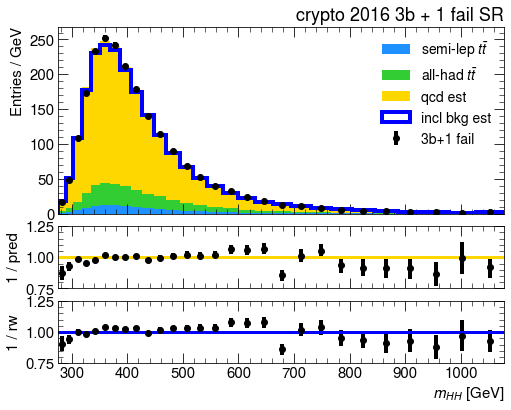

In [105]:
ttbarPreFit(unblind=True)

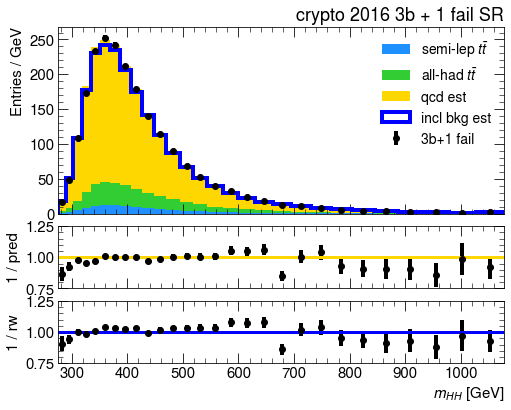

In [113]:
ttbarPreFit(unblind=True,fs=[0.9664195 , 1.1, 1.0011778 ])

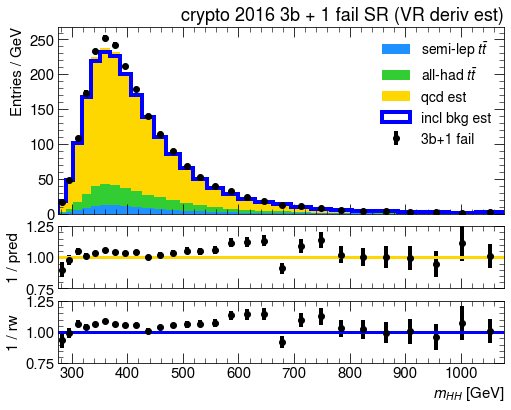

In [106]:
ttbarPreFit(unblind=True,train='VR')

In [ ]:
ttbarPreFit(unblind=True)

In [75]:
dat.ntag.max()

3

In [76]:
dfi = cat_sel(dat[dat.X_wt_tag > 1.5], bcat)
obs = np.histogram(dfi['m_hh'],e_uf)[0]    

In [80]:
dat.head()

pass_vbf_sel  X_wt_tag  rw_to_3b1f  ntag  minQ        m_hh      X_hh  \
0         False  5.017101        True     2     1  400.801331  1.036359   
1         False  5.697348        True     2     1  490.984985  1.108583   
2         False  4.782486        True     2     1  374.754547  1.597552   
3         False  3.134141        True     2     1  320.685883  0.627865   
4         False  6.405104        True     2     1  619.658691  1.415064   

    dEta_hh  NN_d231f_weight_bstrap_med_16  NN_d231f_weight_bstrap_IQR_16  \
0  0.201769                       0.031452                       0.011256   
1  1.349937                       0.072791                       0.014920   
2  0.843274                       0.049580                       0.012980   
3  0.329589                       0.049655                       0.025373   
4  0.301860                       0.142345                       0.031966   

   NN_d231f_weight_VRderiv_bstrap_med_16    pT_h1_j1    pT_h1_j2    pT_h2_j1  \
0                               0.067433  121.687027   83.354614   82.285614   
1                               0.069555  122.359413   83.152969  102.272507   
2                               0.051260   93.895462   61.416775  124.657036   
3                               0.065423   58.136486   51.122887   76.336441   
4                               0.129833  272.728210  145.985413  108.233940   

    pT_h2_j2  
0  71.984291  
1  63.341671  
2  51.159668  
3  41.160923  
4  98.521896

In [134]:
np.histogram(dat.loc[(dat.X_wt_tag > 1.5)&dat.rw_to_3b1f,'m_hh'],e_uf,
             norm*dat.loc[(dat.X_wt_tag > 1.5)&dat.rw_to_3b1f,'NN_d231f_weight_bstrap_med_16'])[0]    

array([ 2570,  7349, 16634, 28721, 39425, 43370, 41085, 37384, 34305,
       27234, 22458, 18751, 14745, 11267,  9518,  7335,  5839,  4770,
        3904,  3142,  2387,  1967,  1586,  1200,   870,   728,   490,
         849])

In [82]:
obs

array([ 232,  677, 1626, 2781, 3958, 4536, 4362, 4015, 3767, 2947, 2516,
       2148, 1725, 1324, 1127,  910,  727,  602,  398,  385,  293,  222,
        180,  133,  103,   84,   60,  107])

In [ ]:
qcd

In [120]:
670.7408984784145/  424.52280293041844

1.579987915486256

In [119]:
326.36956050394394/118.01675562299789

2.7654510478709042

In [136]:
ahm = (ah.X_wt_tag>1.5) & ah[f'rw_to_{bcat}']

ah_2b = np.histogram(ah.loc[ahm,'m_hh'],e_uf,
                     weights=ah.loc[ahm,'NN_d231f_weight_bstrap_med_16']*ah.loc[ahm,'mc_sf'])[0]


In [ ]:
ah.loc[ah.X_wt_tag>1.5,'m_hh']

In [ ]:
h

In [ ]:
# fig, ax  = plt.subplots(3,1,figsize=(width, height), sharex=True,
#                         gridspec_kw={"height_ratios": [.6,.2,.2],
#                                      "hspace":0.12, "left":0.1, "bottom":bottom})


# est2 = 0
# for df,pi,c,l,w_col in zip([sl,ah,dat],[.85,.5,1],colors,labels,
#                            ['mc_sf','mc_sf',f'NN_{wl}_weight_bstrap_med_{yr}']):

#     if w_col == 'mc_sf':
#         dfi = cat_sel(df[df.X_wt_tag > 1.5], bcat)
#     else:
#         dfi = df[df[f'rw_to_{bcat}'] & (df.X_wt_tag > 1.5)]
#     h = np.histogram(dfi['m_hh'],e,weights=dfi[w_col])[0]
    
#     ax[0].hist(xx,e, weights=pi*h/w,bottom=est/w,color=c,label=l)
#     est2+=pi*h

# # Inclusive rw est
# rw_mask = dat[f'rw_to_{bcat}'] & (dat.X_wt_tag > 1.5)
# rw_incl = np.histogram(dat.loc[rw_mask,'m_hh'],e, 
#                        weights=norm*dat.loc[rw_mask,f'NN_{wl}_weight_bstrap_med_{yr}'])[0]

# ax[0].hist(xx,e,histtype='step',color='b',lw=lw,weights=rw_incl/w,label='incl bkg est')

# if bcat == '3b1f':
#     ax[0].errorbar(xx,obs/w,np.sqrt(obs)/w,label='3b+1 fail',**ekwargs)

#     # Add some subpanels
#     ax[1].errorbar(xx,obs/est,np.sqrt(obs)/est,**ekwargs)
#     ax[2].errorbar(xx,obs/rw_incl,np.sqrt(obs)/rw_incl,**ekwargs)

# ax[1].plot(e,np.ones_like(e),color=colors[-1])
# ax[2].plot(e,np.ones_like(e),color='b')

# # Plot beautification
# ax[0].set_xlim(e[0],e[-1])
# ax[0].set_title(f'crypto 2016 {bcat_to_label[bcat]} SR',loc='right')
# ax[0].legend()
# ax[0].set_ylabel('Entries / GeV',y=1,ha='right')

# ax[1].set_ylabel('1 / pred')
# ax[2].set_ylabel('1 / rw')

# for axi in ax[1:]:
#     axi.set_ylim(.75,1.25)

# ax[-1].set_xlabel('$m_{HH}$ [GeV]',x=1,ha='right')



**Conclusion:** This is definitely a *way* of correcting the problem, but unfortunately, it does seem like a potential *over-correction* of the problem.

I *think* I do need to propagate through to the post-fit plots and the limits though...

Some parameters I *could* play with in this set up is the $X_{wt}$ cut used to define the norms,  but it probably should be a higher priority to rinse and repeat with the quadrant setup honestly.

In [ ]:
p

In [ ]:
p_vr

In [ ]:
incl_std  = systs(dat[dat.X_wt_tag > 1.5], norm=norm, norm_VR=norm_VR, 
                  yr=yr, bins=e, b_cat=bcat, 
                  col='m_hh', var='HT', cutoff=300, normalize=False)

incl_norm = systs(dat[dat.X_wt_tag > 1.5], norm=norm, norm_VR=norm_VR, 
                yr=yr, bins=e, b_cat=bcat, 
                col='m_hh', var='HT', cutoff=300, normalize=True)

In [ ]:
new_std = systs(dat[dat.X_wt_tag > 1.5], norm=p[-1], norm_VR=p_vr[-1], 
            yr=yr, bins=e, b_cat=bcat, 
            col='m_hh', var='HT', cutoff=300, normalize=False)

new_norm = systs(dat[dat.X_wt_tag > 1.5], norm=p[-1], norm_VR=p_vr[-1], 
            yr=yr, bins=e, b_cat=bcat, 
            col='m_hh', var='HT', cutoff=300, normalize=True)

In [ ]:
incl_norm[-1],new_norm[-1]

In [ ]:
#iw, ii = 1,3 # high HT
iw, ii = 2,4 # high HT

for out,l,c,ls in zip([incl_std,incl_norm,new_std,new_norm],
                      ['incl','incl norm','new','new norm'],
                      ['b']*2+['gold']*2,['-','--']*2):

    b = out[0]
    
    plt.plot(xx,out[iw]/b,color=c,ls=ls,label=l)
    plt.plot(xx,out[ii]/b,color=c,ls=ls)
    
plt.legend(loc='upper left',fontsize=12)
plt.xlabel('m_hh')
plt.ylabel('var / nom')
plt.title('high HT syst')

In [5]:
bStr = ' '.join([str(ei) for ei in e])
bStr

'275 289 303 318 334 351 369 387 406 427 448 470 494 519 544 572 600 630 662 695 730 766 804 845 887 931 978 1027 1078'

In [ ]:
cat_sel

In [146]:
ahi = cat_sel(ah[ah.X_wt_tag > 1.5],bcat)
h_ah = np.histogram(ahi['m_hh'],e_uf,weights=ahi['mc_sf'])[0]
    
sli = cat_sel(sl[sl.X_wt_tag > 1.5],bcat)
h_sl = np.histogram(sli['m_hh'],e_uf,weights=sli['mc_sf'])[0]

In [ ]:
p[1]*h_ah

In [139]:
np.array(ws_in['channels'][0]['samples'][1]['data'])

array([ 253.18171302,  710.77281536, 1603.48623429, 2799.90493499,
       3868.57551461, 4310.36271619, 4181.24372669, 3860.79259083,
       3616.256738  , 2929.94979613, 2443.07011526, 2061.10170031,
       1648.83999496, 1264.71052139, 1079.35625545,  833.3916627 ,
        668.79220202,  551.51277779,  456.425593  ,  373.82041438,
        279.05833575,  231.17739366,  189.56487397,  144.06346858,
        109.36412845,   94.46420545,   61.09457753,  113.71851402])

In [149]:
p[1]*h_ah

array([ 28.92806514,  68.49424324, 182.33700812, 342.94913515,
       520.61096512, 567.78597303, 556.19723957, 544.39156402,
       523.37624092, 439.01653181, 405.24963875, 356.14550472,
       281.99569873, 237.48534343, 201.28738413, 153.64792852,
       132.98464633, 107.33904936,  80.46161158,  66.82577714,
        45.16357819,  41.46183261,  31.86871351,  22.31177875,
        19.28410752,  14.24672994,   8.22960857,  15.69357573])

In [150]:
np.array(ws_in['channels'][0]['samples'][3]['data'])

array([ 15.07039463,  35.44454014,  74.14187028, 139.08644747,
       184.39012578, 225.68362977, 220.425244  , 199.80066616,
       191.3531875 , 167.86603521, 142.07787608, 123.93071019,
       105.74683103,  81.42764113,  71.39370431,  55.67803224,
        41.47995529,  32.99905074,  27.04619604,  20.58826038,
        16.26762046,  12.21754855,  11.29155346,   8.16158017,
         4.39500644,   3.06714974,   3.04305017,   4.91477153])

In [151]:
p[0]*h_sl

array([ 15.07039463,  35.44454014,  74.14187028, 139.08644747,
       184.39012578, 225.68362977, 220.425244  , 199.80066616,
       191.3531875 , 167.86603521, 142.07787608, 123.93071019,
       105.74683103,  81.42764113,  71.39370431,  55.67803224,
        41.47995529,  32.99905074,  27.04619604,  20.58826038,
        16.26762046,  12.21754855,  11.29155346,   8.16158017,
         4.39500644,   3.06714974,   3.04305017,   4.91477153])

In [ ]:
p[0]*h_sl

In [ ]:
np.array(ws_in['channels'][0]['samples'][3]['data'])

**And now get the BS shape**

In [ ]:
bs = calc_bstrap(dat[dat.X_wt_tag > 1.5],'m_hh',yr,norm,norm_IQR,e,bcat)

**Sean's proposal:** For the QCD estimate, use (full estimate - ttbar)*SF

In [ ]:
nom, lowVRw, highVRw, lowVRi, highVRi,norm_factor = new_norm

In [ ]:
bcat

In [ ]:
bs

In [ ]:
np.array(ws_in['channels'][0]['samples'][1]['modifiers'][0]['data'])

In [ ]:
nom

In [ ]:
np.array(ws_in['channels'][0]['samples'][1]['data'])

In [ ]:
plt.hist(xx,e,histtype='step',weights=bs/rw_incl,
         color='b',lw=lw,label='inclusive rw')

bs_SF = np.sum(nom)/np.sum(rw_incl*norm)
plt.hist(xx,e,histtype='step',weights=bs_SF*bs/nom,
         color='gold',lw=lw,label='QCD est')

plt.xlabel('$m_{hh}$ [GeV]',ha='right',x=1)
plt.ylabel('Bootstrap  / nominal',ha='right',y=1)

plt.xlim(e[0],e[-1])
plt.legend(loc='upper left')
plt.title(f'20{yr} {bcat} SR (rings)')
plt.savefig(f'{figDir}/BS_err_cf_sr{yr}_{bcat}.pdf')

In [ ]:
os.listdir(figDir)

Ok, so this is the inclusive BS error, I think to get the corresponding error on the nominal estimate.

**Awesome** I think this looks like I have all the relevant pieces now :)

In [ ]:
smi = cat_sel(sm[sm.X_wt_tag > 1.5],bcat)
h_sm = np.histogram(smi['m_hh'],e,weights=smi['mc_sf'])[0]

In [ ]:
np.sum(h_sm) #*1.5

In [ ]:
np.sum(sm.loc[(sm.ntag>=4)& (sm.X_wt_tag > 1.5),'mc_sf'])

In [ ]:
h_sm

In [ ]:
p[1]

In [ ]:
p_vr[1]/p[1]

In [ ]:
2-p_vr[1]/p[1]

In [ ]:
mask = dat[f'rw_to_{bcat}'] & (dat.X_wt_tag > 1.5)

poiss_raw = np.sqrt(np.histogram(dat.loc[mask,'m_hh'],e,
                weights=dat.loc[mask,f'NN_{wl}_weight_bstrap_med_{yr}']**2)[0])

In [ ]:
poisson_err = p[-1] * poiss_raw

In [ ]:
chans  = []

unshare_label = str(yr)+bcat
mods = []

label=unshare_label

# Poiss + BS
mods.append({'name': 'uncorr_bkguncrt'+unshare_label, 
             'type': 'shapesys',
             'data': list(np.sqrt( poisson_err**2 + bs_SF*bs**2))
            })
# shape
mods.append({'name': 'low_HT'+label,  'type':'histosys', 
             "data":{"lo_data":list(lowVRi), 
                     "hi_data":list(lowVRw)}})
mods.append({'name': 'high_HT'+label, 'type':'histosys', 
             "data":{"lo_data":list(highVRi),
                     "hi_data":list(highVRw)}})
# norm
mods.append({'name': 'bkg_norm'+label,'type':'normsys',  
             "data":{"lo": 2 - norm_factor,
                     "hi": norm_factor}})

#Add mu as a normfactor
sig_mods = [{'name': 'mu', 'type': 'normfactor', 'data': None }]

channel = { 'name': 'channel'+unshare_label,
            'samples': [
                {
                    'name': 'signal'+unshare_label,
                    'data': list(h_sm),
                    'modifiers': sig_mods
                },
                {
                    'name': 'background'+unshare_label,
                    'data': list( nom),
                    'modifiers': mods
                },
                {
                    'name': 'allhad'+unshare_label,
                    'data': list( p[1]* h_ah),
                    'modifiers': [
                        {'name': 'bkg_norm'+label,
                         'type':'normsys',  
                         "data": {"lo":2 - p_vr[1]/p[1],
                                  "hi": p_vr[1]/p[1]}
                        }
                    ]
                },
                {
                    'name': 'semilep'+unshare_label,
                    'data':list( p[0]* h_sl),
                    'modifiers': [
                        {'name': 'bkg_norm'+label,
                         'type':'normsys',  
                         "data": {"lo": 2 - p_vr[0]/p[0],
                                  "hi": p_vr[0]/p[0]}
                        }
                    ]
                }               
            ],
          }

chans.append( channel )

In [ ]:
norm_factor

In [ ]:
type(p_vr[0]/p[0])

In [ ]:
spec = {'channels' : chans,
        'observations':             
            [{
               'name': 'channel'+unshare_label,
               'data': list(obs),
            }]
       }

#Unbound mu for ws
meas_params = [{ "name": "mu", "bounds": [[-1000, 1000000]], "inits":[1.0] }]
spec['measurements'] = [
                         {
                            'name': 'Measurement',
                            'config': {
                                'poi': 'mu',
                                'parameters': meas_params
                            }
                         }
                       ]
spec['version'] = '1.0.0'

w = pyhf.Workspace(spec)

m = w.model(
        measurement_name="Measurement",
        modifier_settings={
            "normsys": {"interpcode": "code4"},
            "histosys": {"interpcode": "code4p"},
        },
    )

d = w.data(m)

In [ ]:
spec_str = str(spec).replace("\'", "\"").replace("None", "null")
out_ws = pyhf.Workspace(json.loads(spec_str))

In [ ]:
jsname = '../stats-results/ggF_PUSH/'
jsname += f'ws_ttbar-{bcat}-systs-HTcut-300.0-{yr}-SM-HH-unblind-preXwt_train.json'
with open(jsname, 'w') as outfile:
    json.dump(out_ws, outfile)

In [ ]:
jsname

In [ ]:
%%bash
ls ../stats-results/ggF_PUSH/ws-3b1f*-preXwt_train*.json

In [ ]:
with open(jsname.replace('.json','_b_only_postfit.json')) as fi:
    pf_ttbar = json.load(fi)

In [ ]:
hs = pf_ttbar['hists'][str(yr)][0]

pre_tt = hs['pre']
post_tt = hs['post']
err_tt = hs['post_err']
obs_i = hs['obs']

In [ ]:
obs==obs_i

In [ ]:
with open('../stats-results/ggF_PUSH/ws-{4b}-systs-HTcut-300.0-16-SM-HH-unblind-preXwt_train_b_only_postfit.json') as fi:
    pf_incl = json.load(fi)

In [ ]:
hs = pf_incl['hists'][str(yr)][0]

pre_in = hs['pre']
post_in = hs['post']
err_in = hs['post_err']
obs_in = hs['obs']

In [ ]:
scale=1
width = 7.75*scale
height = 5.92*scale
bottom = 0.11

lw=4

fig, ax  = plt.subplots(3,1,figsize=(width, height), sharex=True,
                        gridspec_kw={"height_ratios": [.6,.2,.2],
                                     "hspace":0.12, "left":0.1, "bottom":bottom})

# Plot the data
xx = 0.5 * (e[1:] + e[:-1])
w  = e[1:] - e[:-1]

# New estimate :)
#est = post_tt
ax[0].hist(xx,e,weights=post_tt/w,histtype='step',color='gold',lw=lw,
           label='bkg est w/ $t\bar{t}$')
    
# Inclusive rw est
ax[0].hist(xx,e,histtype='step',color='b',lw=lw,weights=post_in/w,label='incl bkg est')

ekwargs = {'color':'k','lw':0,'elinewidth':lw,'marker':'o'}
ax[0].errorbar(xx,obs_i/w,np.sqrt(obs_i)/w,label=bcat_to_label[bcat],
               **ekwargs)


# Add some subpanels
ax[1].errorbar(xx,obs/post_tt,np.sqrt(obs)/post_in,**ekwargs)
ax[1].plot(e,np.ones_like(e),color=colors[-1])

ax[2].errorbar(xx,obs/post_in,np.sqrt(obs)/post_in,**ekwargs)
ax[2].plot(e,np.ones_like(e),color='b')

# Plot beautification
ax[0].set_xlim(e[0],e[-1])
ax[0].set_title('crypto 2016 SR, post-fit',loc='right')
ax[0].legend()
ax[0].set_ylabel('Entries / GeV',y=1,ha='right')

ax[1].set_ylabel('1 / pred')
ax[2].set_ylabel('1 / rw')

for axi in ax[1:]:
    #axi.set_ylim(.75,1.25)
    axi.set_ylim(.95,1.05)

ax[-1].set_xlabel('$m_{HH}$ [GeV]',x=1,ha='right')

In [6]:
from test_limits import mu_finder, probit, quick_bands

In [28]:
with open('../stats-results/ggF_PUSH/ws-4b-systs-HTcut-300.0-16-SM-HH-ttbar_test.json') as fi:
    wsi = json.load(fi)

In [29]:
ws = pyhf.Workspace(wsi)

# Step 2: Define the pyhf model and (Aimov - B only) dataset
m = ws.model( measurement_name="Measurement",
              modifier_settings={
                    "normsys": {"interpcode": "code4"},
                    "histosys": {"interpcode": "code4p"},
                },
            )
d = ws.data(m)


In [33]:
19.5/17.8

1.095505617977528

In [34]:
19.5/15.1

1.2913907284768211

In [30]:
find = mu_finder(m,d,'pytorch')

Running with pytorch with 64b precision


In [31]:
find.test_mu(19.65)

Param: 2, mu: 19.650, CLs: 0.050


tensor(2.2012e-05)

In [32]:
lims = find.run_scan()

Initial guess for bands (mu guess = 1.00):
[14.90772339 20.01364676 27.78058253 38.65519153 51.82002116]
Beginning optimization, mu valid to 0.01
Finding med_mu for alpha = 0.05
obs tensor(0.0002)
Param: 2, mu: 14.908, CLs: 0.000
obs tensor(2.5052e-18)
Param: 2, mu: 51.820, CLs: 0.000
Looks like initial guess was bad? Expanding for one more try
obs tensor(0.0176)
Param: 2, mu: 7.454, CLs: 0.018
obs tensor(5.1428e-48)
Param: 2, mu: 103.640, CLs: 0.000


ValueError: f(a) and f(b) must have different signs

In [ ]:
lims = find.run_scan_linear(upper_bound=50,npoints=10)

In [ ]:
lims = find.run_scan(init_mu=2)

In [ ]:
lims = find.run_scan(init_mu=5)

**With cats?**

Michael was brainstorming before if we could apply an $\eta$ dependent systematic, and so I was *wondering* if this might be applicable here?